In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import lag_plot,autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
import time 

import scipy
import csv
import getpass
import pyodbc

import warnings
pio.renderers.default = 'notebook'
warnings.filterwarnings("ignore")
%matplotlib inline

- ### Connect into SQL-Database server

In [2]:
server = '192.168.122.56\Mohamed'
database = 'Sales_OLTP'
username = getpass.getpass("Please Enter your Login")
password = getpass.getpass("Please Enter your Password")
port = '1433'
Path = "/home/mohamed/Desktop/sales.csv"

connection_string = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server},{port};DATABASE={database};UID={username};PWD={password}'

try:
    connection = pyodbc.connect(connection_string)

    cursor = connection.cursor()
    
    query = """SELECT  DueDate,sum(TotalDue) as TotalDue
                from Sales_OLTP.Sales.SalesOrderHeader
                Group by DueDate
                Order by DueDate
            """

    cursor.execute(query)

    rows = cursor.fetchall()

    csv_file_path = 'sales_data.csv'

    with open(Path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)

        writer.writerow([desc[0] for desc in cursor.description])

        for row in rows:
            writer.writerow(row)

    print(f"Data has been exported successfully to {csv_file_path}")

    cursor.close()
    connection.close()

except Exception as e:
    print(f"Error: {e}")


Please Enter your Login········
Please Enter your Password········
Data has been exported successfully to sales_data.csv


- ### Loading data¶

In [3]:
df = pd.read_csv("./data/sales.csv",index_col="DueDate")
df.index = pd.to_datetime(df.index)

In [3]:
df = df.tz_localize("UTC").tz_convert("Africa/Cairo")

- ### Description of data

In [4]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1124 entries, 2011-06-12 02:00:00+02:00 to 2014-07-12 02:00:00+02:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TotalDue  1124 non-null   float64
dtypes: float64(1)
memory usage: 17.6 KB
None


TotalDue
count  1.124000e+03
mean   1.096235e+05
std    4.845919e+05
min    7.725036e+02
25%    1.559133e+04
50%    2.382283e+04
75%    4.171030e+04
max    4.800611e+06

- ### visualize time-series data

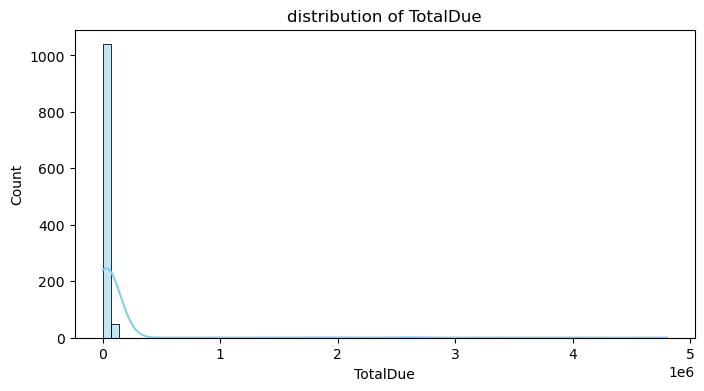

In [5]:
plt.figure(figsize=(8, 4))
sns.histplot(df.TotalDue, bins=70, kde=True, color="skyblue", edgecolor="black");
plt.title("distribution of TotalDue")
plt.show()

In [6]:
fig = px.line(df, x=df.index, y=df.TotalDue, title='TotalDue over Time')

fig.show()

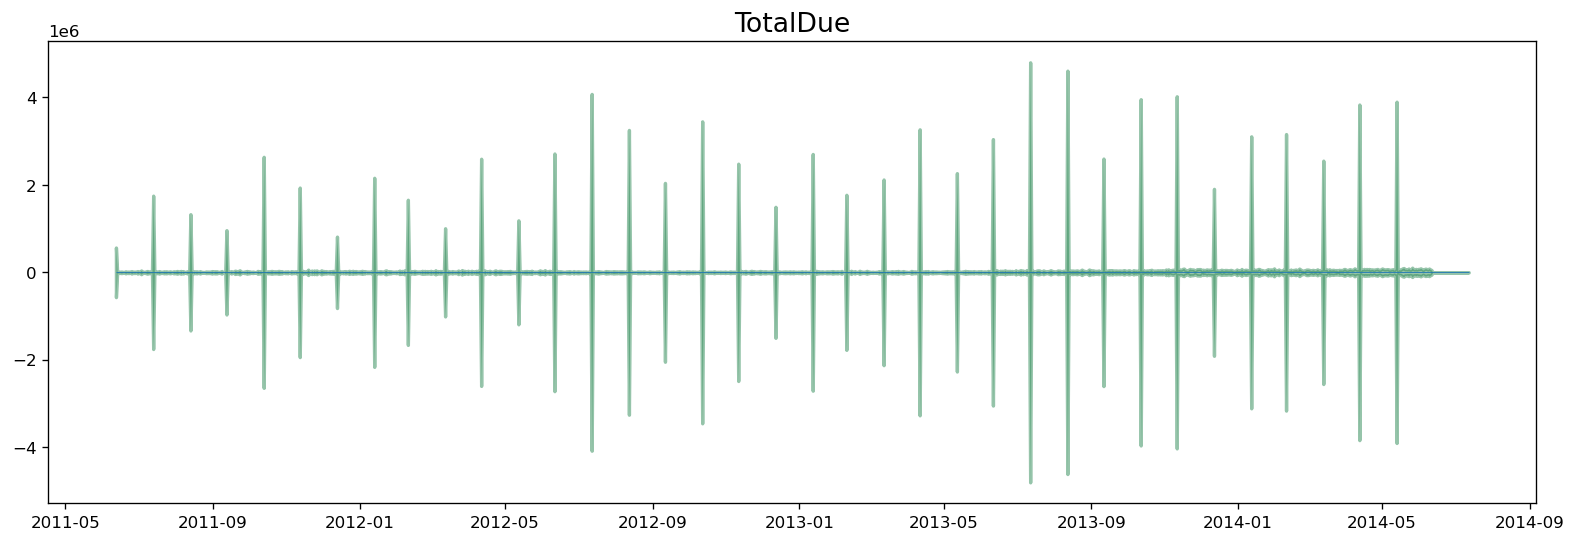

In [7]:
x = df.index
y1 = df["TotalDue"].values

fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.title('TotalDue', fontsize=16)
plt.hlines(y=0, xmin=np.min(x), xmax=np.max(x), linewidth=.5)
plt.show()

- #### from line chart above i can say this time-series is non stationary But i will verify this using the mathematical method (ADF).

- # Augmented Dickey-Fuller (ADF) test:
- First, I will check if the series is stationary using the Augmented Dickey Fuller test (ADF Test), from the statsmodels package. The reason being is that we need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.
- The null hypothesis (Ho) of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we reject the null hypothesis and infer that the time series is indeed stationary.
- So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing. 

In [8]:
result = adfuller(df)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t\t{key}: {value}')


ADF Statistic: -34.359333112713145
p-value: 0.0
Critical Values:
		1%: -3.4361864296062166
		5%: -2.864117116658563
		10%: -2.5681421294173714


* #### from ADF-test above ADF statistic is more negative than the critical values at the 1%, 5%, or 10% levels and p-value = 0.0 is greater than 0.05, so We Must reject the null hypothesis and conclude that the time series is stationary.
    *  i can say Differencing equal 0 (d=0)

- ### I will find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.


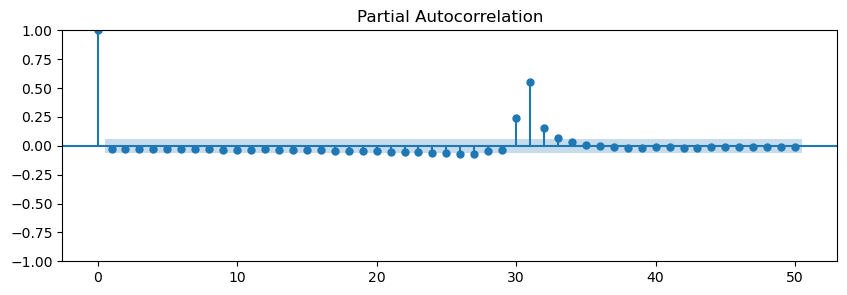

In [9]:
fig, axes = plt.subplots(figsize=(10,3), dpi= 100)
plot_pacf(df, lags=50, ax=axes)
plt.show()

- We can see that the PACF lag (P)  **from (30) TO (33)**  is quite significant since it is well above the significance line. 

- #### we will look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.


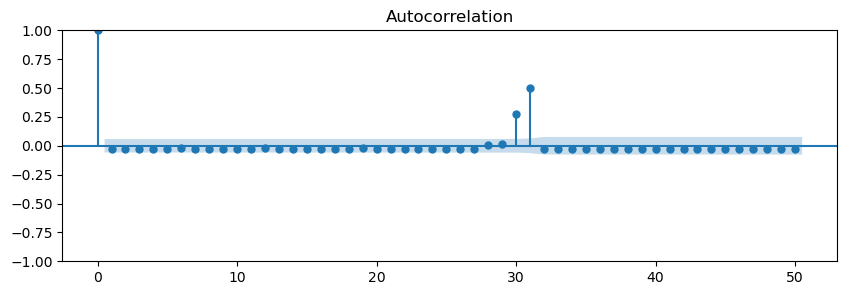

In [10]:
fig, axes = plt.subplots(figsize=(10,3), dpi= 100)
plot_acf(df, lags=50, ax=axes)
plt.show()

- We can see that the ACF lag (q) 1

- ### Now, we have determined the values of p, d and q. We have everything needed to fit the ARIMA model. We will use the ARIMA() implementation in the statsmodels package.
- hyperparameters
    - p -> (30-33)
    - q -> (30-31)
    - d -> 0

- ### Training the model 

In [11]:
lags = np.arange(30,34,1) 
MAs = np.arange(30,32,1)            
best_model = None
best_aic = float('inf')   

for p in lags:
    for q in MAs:
        try:
            model = ARIMA(df['TotalDue'], order=(p, 0, q))
            model_fit = model.fit()

            print(f"Fitted ARIMA({p},0,{q}) - AIC: {model_fit.aic}")

            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_model = model_fit

        except Exception as e:
            print(f"Failed to fit ARIMA({p},0,{q}): {e}")

if best_model:
    print("\nBest Model Summary:")
    print(best_model.summary())
else:
    print("No valid model found.")


Fitted ARIMA(30,0,30) - AIC: 32166.897912468557
Fitted ARIMA(30,0,31) - AIC: 32089.213183022435
Fitted ARIMA(31,0,30) - AIC: 32027.200164254522
Fitted ARIMA(31,0,31) - AIC: 32050.843698195888
Fitted ARIMA(32,0,30) - AIC: 32022.62102025915
Fitted ARIMA(32,0,31) - AIC: 32042.500686776788
Fitted ARIMA(33,0,30) - AIC: 32013.67674092082
Fitted ARIMA(33,0,31) - AIC: 32008.658113045793

Best Model Summary:
                               SARIMAX Results                                
Dep. Variable:               TotalDue   No. Observations:                 1124
Model:               ARIMA(33, 0, 31)   Log Likelihood              -15938.329
Date:                Tue, 15 Oct 2024   AIC                          32008.658
Time:                        16:12:17   BIC                          32340.285
Sample:                             0   HQIC                         32133.982
                               - 1124                                         
Covariance Type:                  opg       

- from this training will choose the model with parametars (33,0,31)

- ### plot the Residuals after training this model

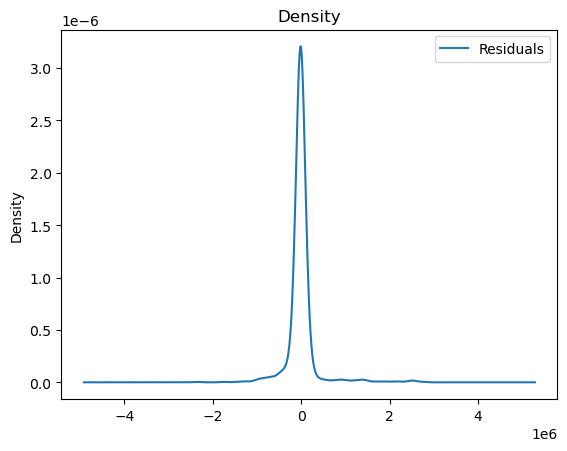

In [12]:
residuals = pd.DataFrame(best_model.resid, columns=['Residuals'])

# Plot residuals 
fig1 = px.line(residuals, 
               y='Residuals', 
               title='Residuals Over Time',
               labels={'index': 'Observation', 'Residuals': 'Residual Value'})

fig2 = residuals.plot(kind='kde', title='Density')
fig1.show()
# fig2.show()

In [13]:
# model = ARIMA(df['TotalDue'], order=(33, 0, 31))
# model_fit = model.fit()

- ### prediction

In [14]:
pred = best_model.get_prediction(start=0, end=len(df)-1)
df['Forecast'] = pred.predicted_mean

df_plot = df[['TotalDue', 'Forecast']].copy()
df_plot['Date'] = df_plot.index
df_plot = df_plot.melt(id_vars='Date', var_name='Type', value_name='Value')

fig = px.line(df_plot, x='Date', y='Value', color='Type', 
              title='ARIMA Model - Forecast vs Actual Data',
              labels={'Date': 'Date', 'Value': 'TotalDue'})

fig.show()

- ### split data and train the model again

In [15]:
split = int(0.8 * len(x))
train, test = df['TotalDue'][:split], df['TotalDue'][split:]

In [16]:
model = ARIMA(train, order=(33, 0, 31))  
fitted = model.fit()

- ### forecasting and validating th model 

In [17]:
forecast_result = fitted.get_forecast(steps=119, alpha=0.05)

fc = forecast_result.predicted_mean
conf = forecast_result.conf_int()

fc_series = pd.Series(fc.values, index=test.index[:len(fc)])
lower_series = pd.Series(conf.iloc[:, 0].values, index=test.index[:len(fc)])
upper_series = pd.Series(conf.iloc[:, 1].values, index=test.index[:len(fc)])


In [18]:
# Plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', name='Training'))

fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name='Actual', line=dict(color='blue')))

fig.add_trace(go.Scatter(x=fc_series.index, y=fc_series, mode='lines', name='Forecast', line=dict(color='orange')))

fig.add_trace(go.Scatter(
    x=fc_series.index, y=upper_series, mode='lines', 
    line=dict(color='gray', width=0), showlegend=False))

fig.add_trace(go.Scatter(
    x=fc_series.index, y=lower_series, mode='lines', 
    line=dict(color='gray', width=0), showlegend=False, 
    fill='tonexty', fillcolor='rgba(128, 128, 128, 0.3)'))

fig.update_layout(
    title='Forecast vs Actuals',
    xaxis_title='Date',
    yaxis_title='Total Due',
    legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.7)', bordercolor='black', borderwidth=1),
    width=1000, height=600
)

fig.show()


In [19]:
aligned_test = test.values[:len(fc)]


def forecast_accuracy(forecast, actual):
    mpe = np.mean((forecast - actual) / actual)
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))
    minmax = 1 - np.mean(np.min([forecast, actual], axis=0) / np.max([forecast, actual], axis=0))
    
    return {'mpe': mpe, 'rmse': rmse, 'minmax': minmax}

accuracy_metrics = forecast_accuracy(fc, aligned_test)
accuracy_metrics


{'mpe': 0.728288216527285,
 'rmse': 444713.4826793588,
 'minmax': 1.4927666289249102}

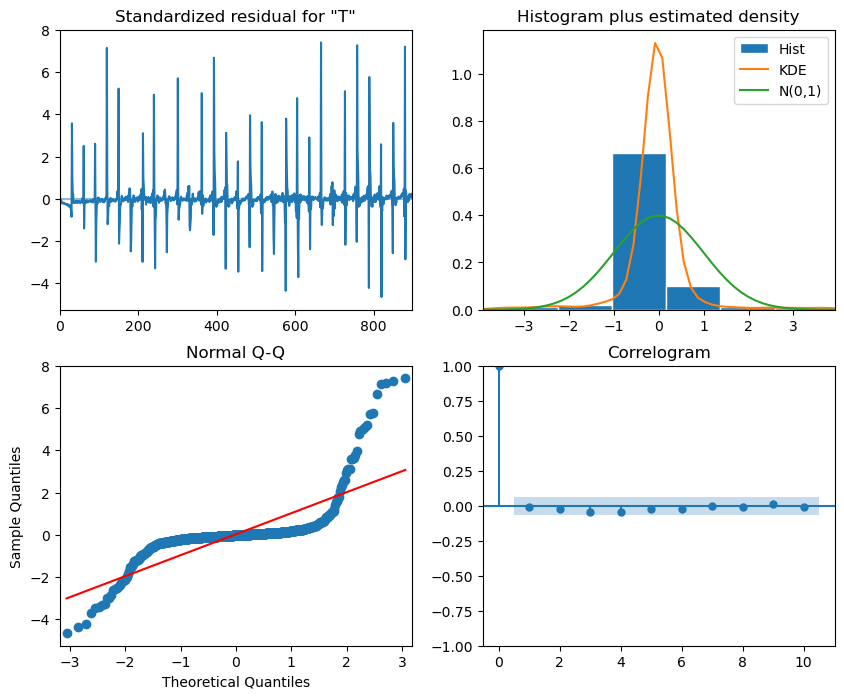

In [20]:
fitted.plot_diagnostics(figsize=(10,8))
plt.show()

- Standardized residual: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

- Histogram: The density plot suggest normal distribution with mean slighlty shifted towards right.

- Theoretical Quantiles: Mostly the dots fall perfectly in line with the red line.

- Correlogram: The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated.

- Overall, the model seems to be a good fit. So, let's use it to forecast but this need deseasonalized

In [21]:
steps = 150  
forecast_result = fitted.get_forecast(steps=steps)  

forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)

forecast_index = pd.date_range(start=test.index[-1], periods=steps + 1, freq='D')[1:]
forecast_series = pd.Series(forecast.values, index=forecast_index)

lower_series = pd.Series(conf_int.iloc[:, 0].values, index=forecast_index)
upper_series = pd.Series(conf_int.iloc[:, 1].values, index=forecast_index)


fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', name='Training',line=dict(color='blue')))
fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name='test', line=dict(color='blue')))

fig.add_trace(go.Scatter(x=forecast_series.index, y=forecast_series, mode='lines', 
                         name='Forecast', line=dict(color='fuchsia')))

fig.add_trace(go.Scatter(x=forecast_series.index, y=lower_series, mode='lines', 
                         name='Lower Bound', line=dict(width=0), fill=None))
fig.add_trace(go.Scatter(x=forecast_series.index, y=upper_series, mode='lines', 
                         name='Upper Bound', line=dict(width=0), fill='tonexty',
                         fillcolor='rgba(128, 128, 128, 0.2)', showlegend=False))

fig.update_layout(
    title='Forecast vs Actuals with Future Predictions',
    xaxis_title='Date',
    yaxis_title='Total Due',
    width=900, height=500,
    legend=dict(yanchor='top', y=0.99, xanchor='left', x=0.01)
)

fig.show()


- From the analysis process of the above model, we notice that the model is good, but there are some problems in this model. The residuals are very large, and the model fits the data well. It is clear to us that this is due to the seasonality present in the data.


- ### deseasonalized

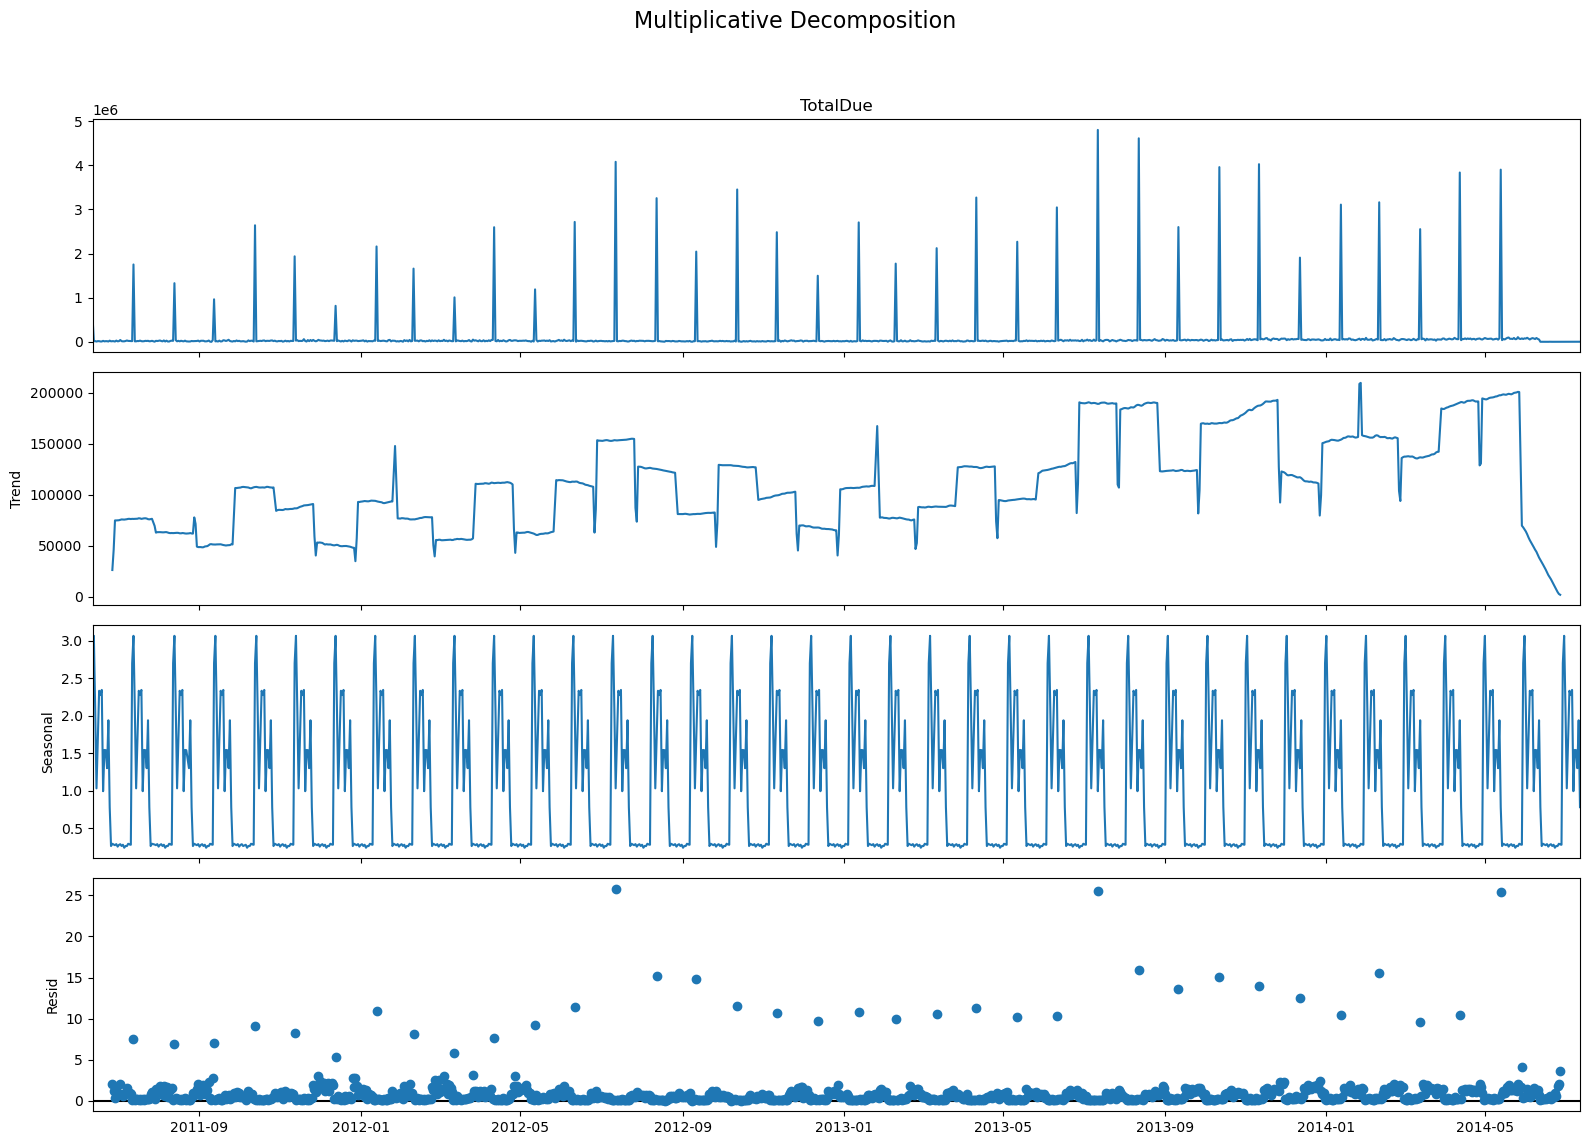

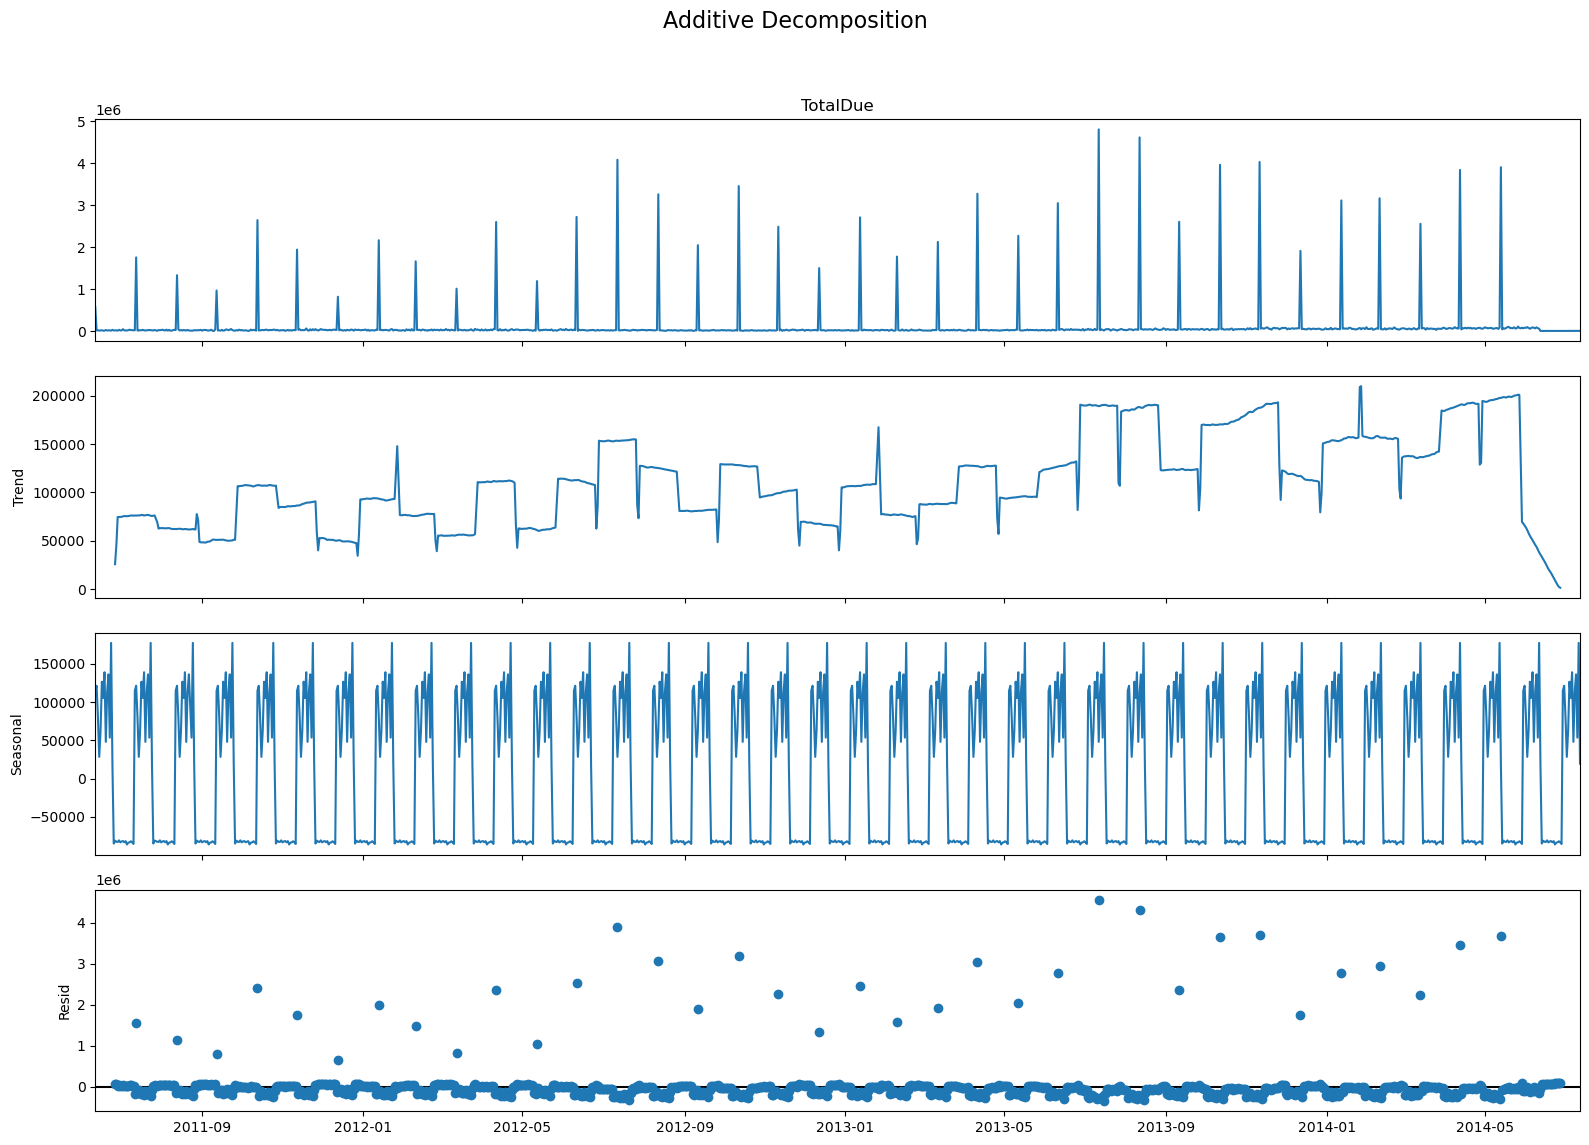

In [22]:
multiplicative_decomposition = seasonal_decompose(df['TotalDue'], model='multiplicative', period=30)

additive_decomposition = seasonal_decompose(df['TotalDue'], model='additive', period=30)

plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [23]:
deseasonalized = (df['TotalDue'].dropna() / multiplicative_decomposition.seasonal).dropna()


# Plot
fig = px.line(deseasonalized,
              x=df.index,
              y=df.TotalDue,
              title='deseasonalized TotalDue over Time',
              labels={'x': 'DueDate', 'y': 'Total Due'})
fig.show()

- ### check again stationary Augmented Dickey-Fuller (ADF) test and ACF and PACF

In [24]:
result = adfuller(deseasonalized)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t\t{key}: {value}')


ADF Statistic: -34.059840588918846
p-value: 0.0
Critical Values:
		1%: -3.4361864296062166
		5%: -2.864117116658563
		10%: -2.5681421294173714


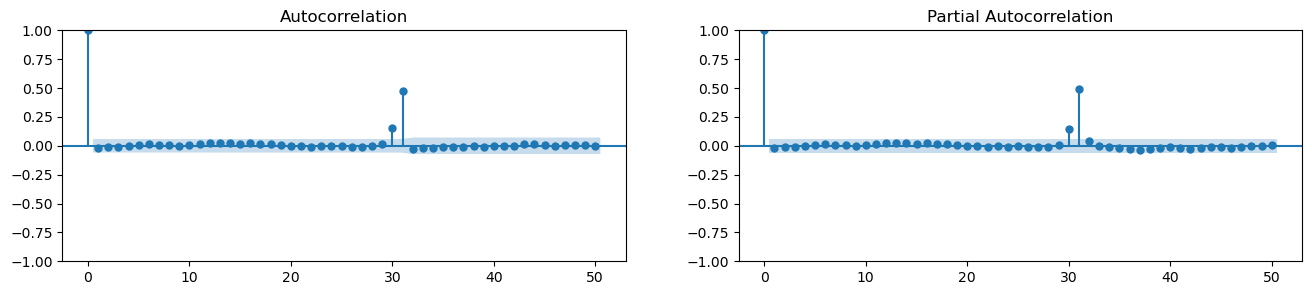

In [25]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(deseasonalized.tolist(), lags=50, ax=axes[0])
plot_pacf(deseasonalized.tolist(), lags=50, ax=axes[1])
plt.show()

- ### plot lags 

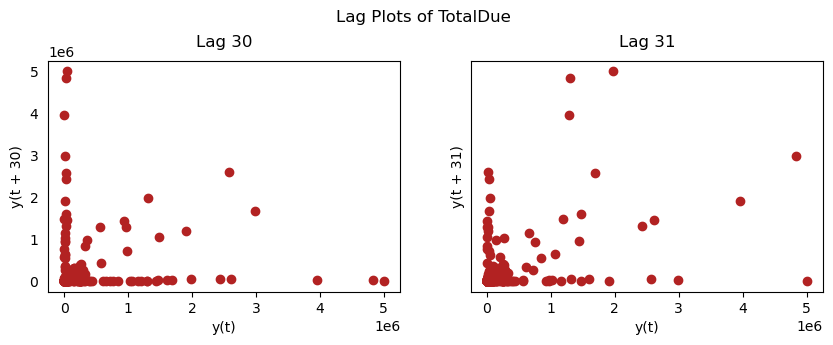

In [26]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

fig, axes = plt.subplots(1, 2, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:2]):
    lag_plot(deseasonalized, lag=i+30, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+30))

fig.suptitle('Lag Plots of TotalDue', y=1.05)    
plt.show()

In [27]:
lags = np.arange(30,32,1) 
MAs = np.arange(30,33,1)            
best_model = None
best_aic = float('inf')   

for p in lags:
    for q in MAs:
        try:
            model = ARIMA(deseasonalized, order=(p, 0, q))
            model_fit = model.fit()

            print(f"Fitted ARIMA({p},0,{q}) - AIC: {model_fit.aic}")

            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_model = model_fit

        except Exception as e:
            print(f"Failed to fit ARIMA({p},0,{q}): {e}")

if best_model:
    print("\nBest Model Summary:")
    print(best_model.summary())
else:
    print("No valid model found.")

Fitted ARIMA(30,0,30) - AIC: 31529.953548983427
Fitted ARIMA(30,0,31) - AIC: 31420.082259036422
Fitted ARIMA(30,0,32) - AIC: 31398.343108113397
Fitted ARIMA(31,0,30) - AIC: 31296.16308961033
Fitted ARIMA(31,0,31) - AIC: 31309.099728508554
Fitted ARIMA(31,0,32) - AIC: 31309.490256154855

Best Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1124
Model:               ARIMA(31, 0, 30)   Log Likelihood              -15585.082
Date:                Tue, 15 Oct 2024   AIC                          31296.163
Time:                        16:22:38   BIC                          31612.716
Sample:                             0   HQIC                         31415.791
                               - 1124                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      

- the best parametar for this model (31,0,30)

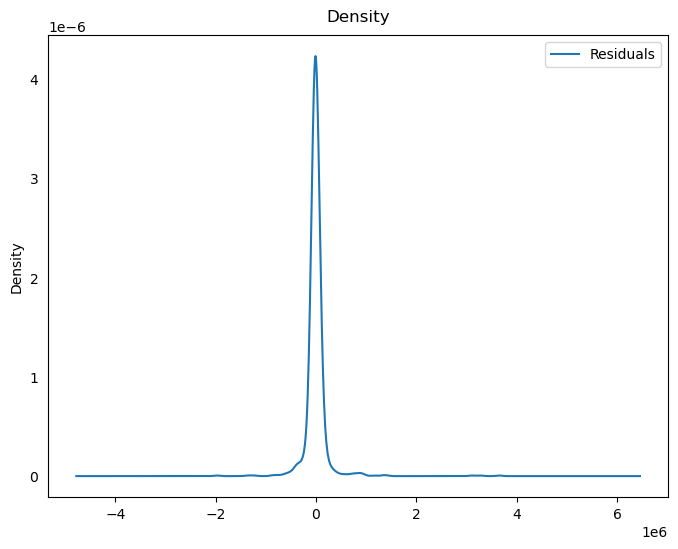

In [28]:
residuals = pd.DataFrame(best_model.resid, columns=['Residuals'])

# Plot residuals 
fig1 = px.line(residuals, 
               y='Residuals', 
               title='Residuals Over Time',
               labels={'index': 'Observation', 'Residuals': 'Residual Value'})

fig2 = plt.figure(figsize=(8, 6))
ax = residuals.plot(kind='kde', title='Density', ax=fig2.add_subplot(111))

fig1.show()
plt.show()

- ### split deseasonalized data and train the model again 

In [29]:
split = int(0.8 * len(x))
train, test = deseasonalized.to_frame()[0][:split], deseasonalized.to_frame()[0][split:]

In [30]:
model = ARIMA(train, order=(31, 0, 30))  
fitted = model.fit()

- ### Forecasting validation

In [31]:
forecast_result = fitted.get_forecast(steps=119, alpha=0.05)

fc = forecast_result.predicted_mean
conf = forecast_result.conf_int()

fc_series = pd.Series(fc.values, index=test.index[:len(fc)])
lower_series = pd.Series(conf.iloc[:, 0].values, index=test.index[:len(fc)])
upper_series = pd.Series(conf.iloc[:, 1].values, index=test.index[:len(fc)])


- ### validation test set

In [32]:
# Plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', name='Training'))

fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name='Actual', line=dict(color='blue')))

fig.add_trace(go.Scatter(x=fc_series.index, y=fc_series, mode='lines', name='Forecast', line=dict(color='orange')))

fig.add_trace(go.Scatter(
    x=fc_series.index, y=upper_series, mode='lines', 
    line=dict(color='gray', width=0), showlegend=False))

fig.add_trace(go.Scatter(
    x=fc_series.index, y=lower_series, mode='lines', 
    line=dict(color='gray', width=0), showlegend=False, 
    fill='tonexty', fillcolor='rgba(128, 128, 128, 0.3)'))

fig.update_layout(
    title='Forecast vs Actuals',
    xaxis_title='Date',
    yaxis_title='Total Due',
    legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.7)', bordercolor='black', borderwidth=1),
    width=1000, height=600
)

fig.show()


In [33]:
aligned_test = test.values[:len(fc)]

def forecast_accuracy(forecast, actual):
    mpe = np.mean((forecast - actual) / actual)
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))
    minmax = 1 - np.mean(np.min([forecast, actual], axis=0) / np.max([forecast, actual], axis=0))
    
    return {'mpe': mpe, 'rmse': rmse, 'minmax': minmax}

accuracy_metrics = forecast_accuracy(fc, aligned_test)
accuracy_metrics


{'mpe': 1.1146247811868633,
 'rmse': 289658.2148717218,
 'minmax': 0.8344191602810813}

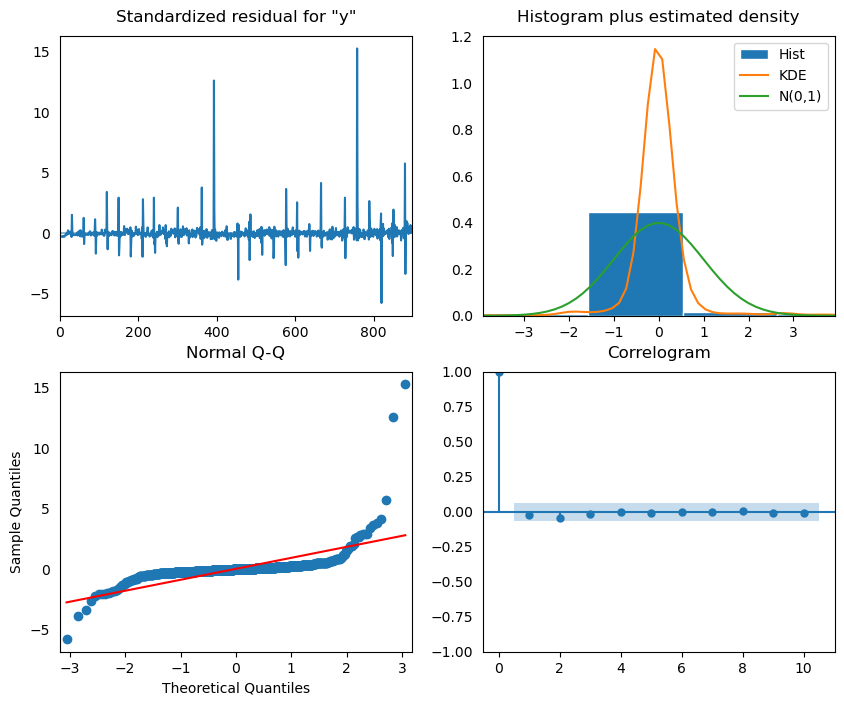

In [34]:
fitted.plot_diagnostics(figsize=(10,8))
plt.show()

- ### After training the model and removing seasonality from the data, we notice that
    - Standardized residual: The residual errors seem to fluctuate around a mean of zero and have a uniform -variance.

    - Histogram: The density plot suggest normal distribution 

    - Theoretical Quantiles: Mostly the dots fall perfectly in line with the red line.

    - Correlogram: The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated.

    - Overall, the model seems to be a good fit. So, let's use it to forecast

- # Final Forecasting 

In [35]:
steps = 150  
forecast_result = fitted.get_forecast(steps=steps)  

forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)

forecast_index = pd.date_range(start=test.index[-1], periods=steps + 1, freq='D')[1:]
forecast_series = pd.Series(forecast.values, index=forecast_index)

lower_series = pd.Series(conf_int.iloc[:, 0].values, index=forecast_index)
upper_series = pd.Series(conf_int.iloc[:, 1].values, index=forecast_index)


fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', name='Training',line=dict(color='blue')))
fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name='test', line=dict(color='blue')))

fig.add_trace(go.Scatter(x=forecast_series.index, y=forecast_series, mode='lines', 
                         name='Forecast', line=dict(color='fuchsia')))

fig.add_trace(go.Scatter(x=forecast_series.index, y=lower_series, mode='lines', 
                         name='Lower Bound', line=dict(width=0), fill=None))
fig.add_trace(go.Scatter(x=forecast_series.index, y=upper_series, mode='lines', 
                         name='Upper Bound', line=dict(width=0), fill='tonexty',
                         fillcolor='rgba(128, 128, 128, 0.2)', showlegend=False))

fig.update_layout(
    title='Forecast vs Actuals with Future Predictions',
    xaxis_title='Date',
    yaxis_title='Total Due',
    width=900, height=500,
    legend=dict(yanchor='top', y=0.99, xanchor='left', x=0.01)
)

fig.show()
